<a href="https://colab.research.google.com/github/ethannaegele/stats531-midterm/blob/main/midterm_exploratory_ethan_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 17.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from arch import arch_model

In [4]:
data = pd.read_csv("DAX_2010-2020.csv") # replace with path when working locally
# Clean date
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.sort_values('Date')
data = data[data['Date'] < '2020-01-01']


data.set_index('Date', inplace=True)
data = data.asfreq('B')  # Business day frequency
data['Open'] = data['Open'].ffill()

df = data.copy()
df = df[['Open']]
df = df[df.index < '2019-01-01']
df["Open"] = df["Open"].str.replace(",", "", regex=False).astype(float) # remove undesirable comma formatting in the price

df2 = df.copy()
df2 = np.log(df['Open'])
df2 = df2.diff().dropna()
df2 = df2 * 100



In [5]:
df2

,Open
Date,
2010-01-05,1.138499
2010-01-06,-0.191283
2010-01-07,-0.258773
2010-01-08,0.196257
2010-01-11,0.485003
...,...
2018-12-25,0.000000
2018-12-26,0.000000
2018-12-27,0.324261


In [6]:
# this code is adapted from Lecture 5
def aic_table(data, P, Q, d=0, model_type='sarimax', dist='normal'):
    table = np.zeros((P+1, Q+1))
    model_type = model_type.strip().lower()
    for p in range(P+1):
        for q in range(Q+1):
            try:
                if model_type == 'sarimax':
                    model = SARIMAX(data,
                                    trend = 'c',
                                    order=(p, d, q))
                elif model_type == 'garch':
                    # if p == 0:
                    #     continue # NaNs only for ARCH(0)
                    model = arch_model(data,
                                       vol='GARCH',
                                       p=p,
                                       q=q,
                                       dist=dist)
                else:
                    raise ValueError
                results = model.fit()
                table[p, q] = results.aic # sarimax, garch have aic attribute
            except:
                table[p, q] = np.nan
    if model_type == 'sarimax':
        df = pd.DataFrame(table,
            index=[f'AR{p}' for p in range(P+1)],
            columns=[f'MA{q}' for q in range(Q+1)])
    elif model_type == 'garch':
        df = pd.DataFrame(table,
            index=[f'ARCH{p}' for p in range(P+1)], # by this, I mean there are is dependence on the p previous epsilon values
            columns=[f'GARCH{q}' for q in range(Q+1)]) # by this, I mean there are q "GARCH" terms in that there is dependence on the q previous sigma^2 values
    else:
        raise ValueError
    return df

In [7]:
def get_metrics(y_true, y_pred):
    metrics = {'Mean Absolute Percentage Error': mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), # MAPE probably not very helpful for this scenario
               'Mean Absolute Error': mean_absolute_error(y_true=y_true, y_pred=y_pred),
               'Mean Squared Error': mean_squared_error(y_true=y_true, y_pred=y_pred)}
    return metrics

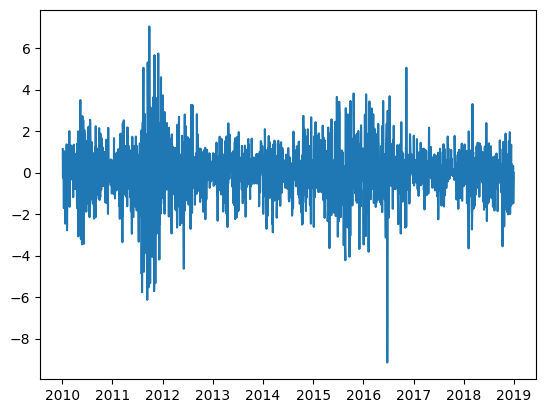

In [8]:
plt.clf()
plt.plot(df2.index, df2)
plt.show()

<Figure size 640x480 with 0 Axes>

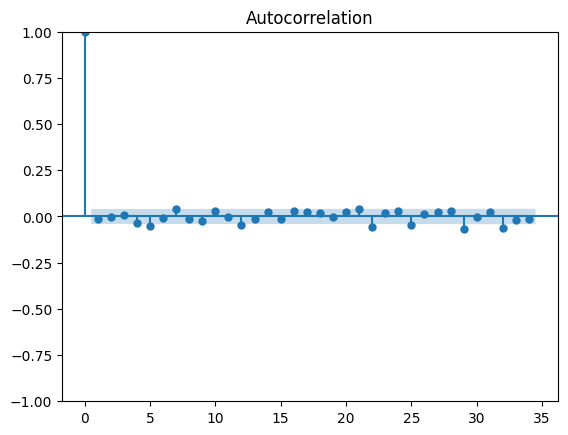

In [9]:
plt.clf()
plot_acf(df2)
plt.show()

ARMA model candidates

In [10]:
aic_table(df2, P = 4, Q = 4)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/st

,MA0,MA1,MA2,MA3,MA4
AR0,7563.129622,7564.801183,7566.788973,7568.602599,7566.673056
AR1,7564.802739,7566.797580,7568.788372,7568.437465,7564.836408
AR2,7566.787521,7568.788195,7570.788288,7566.265596,7562.764135
AR3,7568.558399,7570.143654,7548.534662,7568.782865,7561.497724
AR4,7567.213400,7565.393773,7564.811900,7568.679512,7553.503778


In [11]:
model_302 = SARIMAX(df2, order=(3, 0, 2), trend='c').fit()
print(model_302.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2345
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -3767.267
Date:                Thu, 19 Feb 2026   AIC                           7548.535
Time:                        04:40:58   BIC                           7588.855
Sample:                    01-05-2010   HQIC                          7563.220
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0592      0.063      0.948      0.343      -0.063       0.182
ar.L1         -0.5229      0.025    -21.114      0.000      -0.571      -0.474
ar.L2         -0.9688      0.017    -56.484      0.0

In [14]:
# roots near unit circle, and numerical issues when fitting model
print(np.absolute(model_302.arroots))
print(np.absolute(model_302.maroots))

[  1.0147086   1.0147086 216.1808602]
[1.02717414 1.02717414]


In [12]:
model_304 = SARIMAX(df2, order=(3, 0, 4), trend='c').fit()
print(model_304.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2345
Model:               SARIMAX(3, 0, 4)   Log Likelihood               -3771.749
Date:                Thu, 19 Feb 2026   AIC                           7561.498
Time:                        04:42:08   BIC                           7613.338
Sample:                    01-05-2010   HQIC                          7580.380
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.015      0.808      0.419      -0.018       0.043
ar.L1          0.7357      0.177      4.154      0.000       0.389       1.083
ar.L2         -0.8074      0.103     -7.811      0.0

In [15]:
print(np.absolute(model_304.arroots))
print(np.absolute(model_304.maroots))

[1.13069219 1.13069219 1.42930858]
[ 1.1039107   1.1039107   1.33665393 12.62792036]


In [16]:
model_404 = SARIMAX(df2, order=(4, 0, 4), trend='c').fit()
print(model_404.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2345
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -3766.752
Date:                Thu, 19 Feb 2026   AIC                           7553.504
Time:                        04:45:48   BIC                           7611.104
Sample:                    01-05-2010   HQIC                          7574.484
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0209      0.020      1.023      0.306      -0.019       0.061
ar.L1          1.0891      0.053     20.366      0.000       0.984       1.194
ar.L2         -1.0656      0.045    -23.717      0.0

In [17]:
# all roots near unit circle, numerical issues when fitting model
print(np.absolute(model_404.arroots))
print(np.absolute(model_404.maroots))

[1.02289276 1.02289276 1.02961725 1.02961725]
[1.03660925 1.03660925 1.02629077 1.02629077]


Based on the root analysis above, only ARMA(3, 4) seemed reliable, but even then, this is for an AIC reduction of less than 2. Other models that showed AIC gains were shown to have numerical issues above.

Thus, a mean + white noise model seems appropriate.

Hence, we can implement the GARCH model since the time series shows volatility clustering.

# GARCH

In [18]:
aic_table(df2, P = 4, Q = 4, model_type='garch')

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12511.672500305396
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7224.294898426158
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3787.5111986121265
Iteration:      4,   Func. Count:     26,   Neg. LLF: 6053.800140820384
Iteration:      5,   Func. Count:     32,   Neg. LLF: 3734.6605169116337
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3734.5910508530965
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3734.5897328946667
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3734.5897271498484
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3734.5897264102487
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3734.5897264102487
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 15028.917965737319
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6084187418

,GARCH0,GARCH1,GARCH2,GARCH3,GARCH4
ARCH0,NaN,NaN,NaN,NaN,NaN
ARCH1,7475.179453,7010.282645,7012.282645,7014.282646,7016.282645
ARCH2,7372.032305,7011.239753,7013.239753,7016.020894,7018.020894
ARCH3,7242.941274,7012.200095,7013.611443,7014.666212,7017.351079
ARCH4,7152.302369,7014.200095,7015.483802,7016.577659,7019.185316


In [19]:
model_g11 = arch_model(df2,
                        vol='GARCH',
                        p=1,
                        q=1).fit()
print(model_g11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15028.917965737319
Iteration:      2,   Func. Count:     15,   Neg. LLF: 60841874189.163315
Iteration:      3,   Func. Count:     23,   Neg. LLF: 435216080.5693495
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3508.321342954471
Iteration:      5,   Func. Count:     35,   Neg. LLF: 15393.242722574276
Iteration:      6,   Func. Count:     43,   Neg. LLF: 3507.4749043014244
Iteration:      7,   Func. Count:     49,   Neg. LLF: 3501.141949982631
Iteration:      8,   Func. Count:     54,   Neg. LLF: 3501.141326834606
Iteration:      9,   Func. Count:     59,   Neg. LLF: 3501.141322482718
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3501.141322481144
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3501.141322482718
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results           

In [22]:
estimated_vol = model_g11.conditional_volatility

# credit to https://blog.quantinsti.com/garch-gjr-garch-volatility-forecasting-python/ for this suggestion
realized_vol = df2.rolling(window=5).std()  # 5-day window for smoothing. Includes data from time t

# comparing GARCH conditional volatility estimate to r_t^2 as this seems to be more common in literature?
# for example, see https://link.springer.com/chapter/10.1007/978-3-030-46347-2_8
realized_vol_v2 = df2**2

<Figure size 640x480 with 0 Axes>

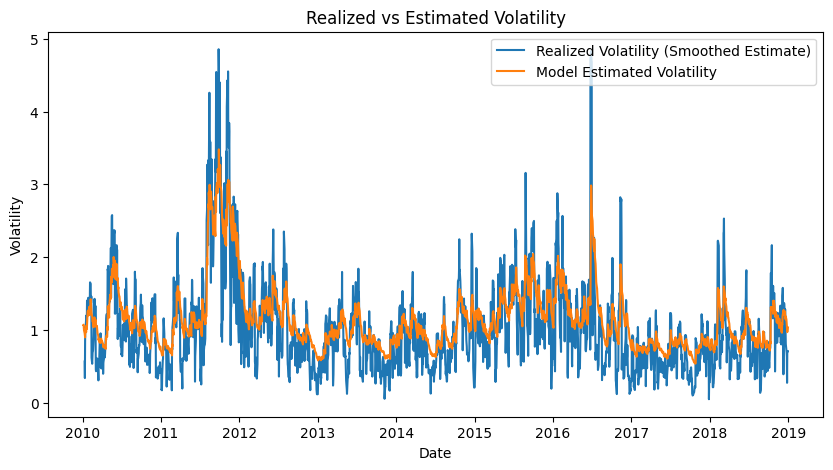

In [23]:
plt.clf()
plt.figure(figsize=(10, 5))

plt.plot(df2.index, realized_vol, label='Realized Volatility (Smoothed Estimate)')
plt.plot(df2.index, estimated_vol, label='Model Estimated Volatility')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Realized vs Estimated Volatility')
plt.legend()

plt.show()

<Figure size 640x480 with 0 Axes>

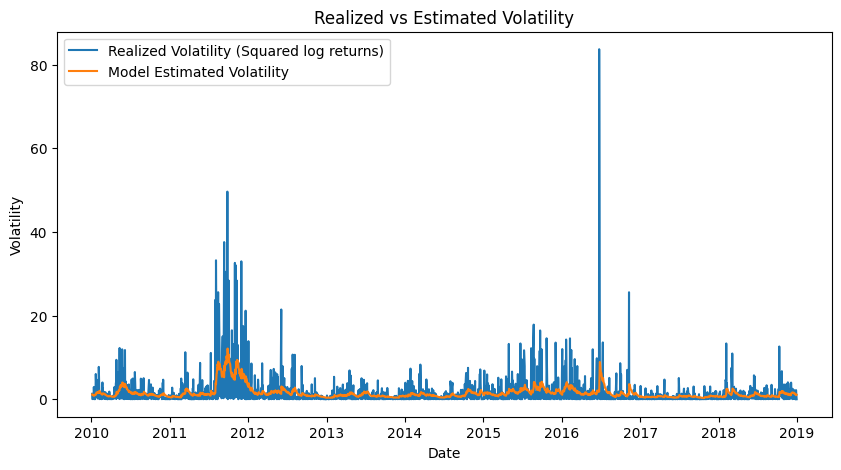

In [24]:
plt.clf()
plt.figure(figsize=(10, 5))

plt.plot(df2.index, realized_vol_v2, label='Realized Volatility (Squared log returns)')
plt.plot(df2.index, estimated_vol**2, label='Model Estimated Volatility')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Realized vs Estimated Volatility')
plt.legend()

plt.show()